In [ ]:
import os
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm  # Import tqdm for progress bar
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from myMLlib import set_seed, plt_confusion

In [32]:
folderpath = '/home/yuqster/files/research/dataset/CNC_mix8'
data_list = []
labels = []

airindex = 0
while os.path.exists(f'{folderpath}/air{airindex}.csv'):
    # 读取数据
    data = pd.read_csv(f'{folderpath}/air{airindex}.csv')
    trans = data.values  
    data_list.append(trans)
    labels.append(0)
    airindex += 1


In [ ]:
material = ['jelo','water','vinegar']
file_name = []
for i in range(3):
    file_name.append([f for f in os.listdir(folderpath) if material[i] in f])
    for path in file_name[i]:
        data = pd.read_csv(f'{folderpath}/{path}')
        trans = data.values
        data_list.append(trans)
        labels.append(i+1)


In [ ]:
X = np.array(data_list).squeeze()
y = np.array(labels).reshape(-1, 1)
X = X[:,0:2000]
print(X.shape)
print(y.shape)
set_seed(42)

(20977, 2000)
(20977, 1)


In [5]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
    else "cpu"
)
print("Using device:", device)

Using device: cuda


In [6]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
scaler = MinMaxScaler(feature_range=(0, 3))
y = scaler.fit_transform(y)
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(y_train)

[[1.]
 [3.]
 [3.]
 ...
 [1.]
 [0.]
 [3.]]


In [7]:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, bidirectional=False)
        # 分类头：把最后一个时间步的隐藏状态映射到类别数
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: [batch, seq_len, input_size]
        output, (hn, cn) = self.lstm(x)
        # hn: [num_layers, batch, hidden_size]
        last_hidden = hn[-1]                # 取最后一层的隐藏状态 [batch, hidden_size]
        logits = self.classifier(last_hidden)  # [batch, num_classes]
        return logits

In [ ]:
model = LSTMModel(input_size=X_train.shape[1], hidden_size=20, num_layers=2, num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

# 4. 将 numpy 数据转为 torch 张量并移动到 device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [24]:
# 5. 训练模型
num_epochs = 3000
train_losses = []

# Convert y_train_tensor to the correct type
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = y_train_tensor.squeeze().long() # Remove extra dimension and convert to long
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
pbar = tqdm(range(num_epochs), desc="Training", leave=True)
for epoch in pbar:
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    torch.cuda.empty_cache()
    pbar.set_postfix(loss=loss.item())


Training: 100%|██████████| 3000/3000 [03:15<00:00, 15.37it/s, loss=0.0159] 


In [25]:
# Evaluate the model
model.eval()
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=2000, shuffle=False)
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.append(predicted.cpu())
        all_labels.append(batch_y.cpu())

# 拼接所有结果
predicted_np = torch.cat(all_preds).numpy()
y_test_np = torch.cat(all_labels).squeeze().numpy()

# 评估
accuracy = accuracy_score(y_test_np, predicted_np)
cm = confusion_matrix(y_test_np, predicted_np)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", cm)

Accuracy: 0.9945980298697172
Confusion Matrix:
 [[ 604    0    0    0]
 [   0 1931    2    1]
 [   0   10 1867    1]
 [   0    9   11 1858]]


Accuracy: 0.9945980298697172
Confusion Matrix:
[[ 604    0    0    0]
 [   0 1931    2    1]
 [   0   10 1867    1]
 [   0    9   11 1858]]


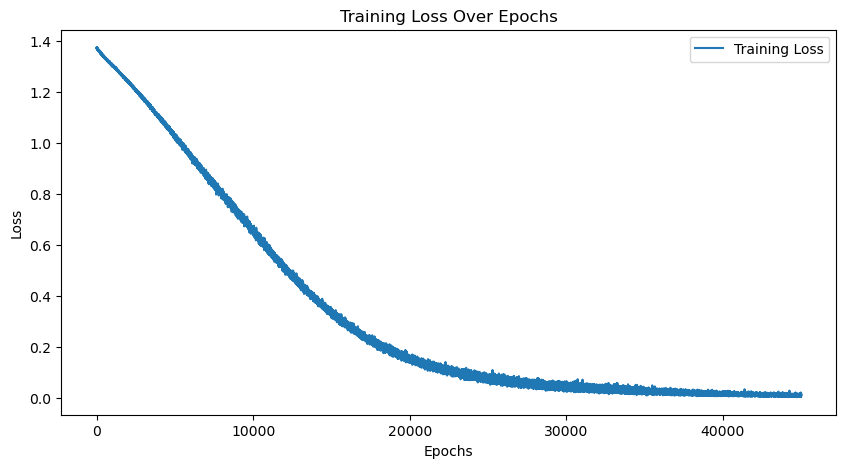

In [26]:
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{cm}')

# 7. 可视化训练损失
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

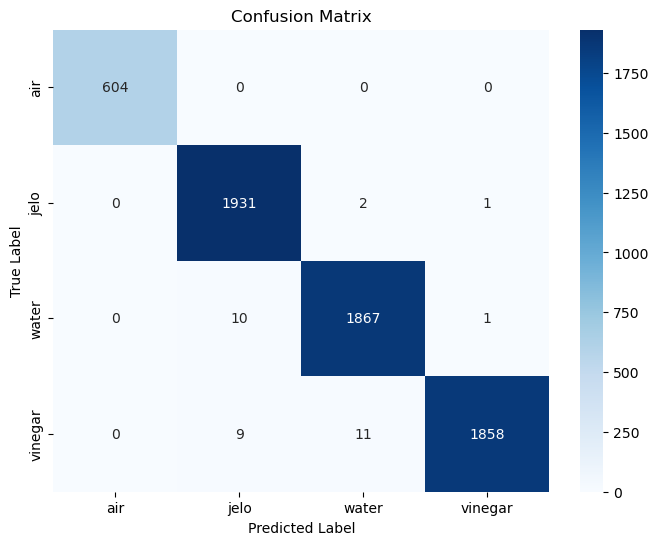

In [43]:
plt_confusion(cm,objects= ['air']+ material)